# Asthma Data Processing
This notebook contains the code for loading, parsing, and preliminary EDA of the asthma data. This data was collected from the Oklahoma State Department of Health Statistics, [OK2SHARE](https://www.health.state.ok.us/index.shtml), with the license for usage in "...monitoring the health of the people of Oklahoma" (full license [here](https://www.health.state.ok.us/)).

The output of this notebook is a processed dataset containing asthma rates of Non-smokers from central oklahoma in the years 2000 and 2003-2023. Note that the raw data itself was collected as the Behavior Risk Factor Surveillance System (BRFSS) [crosstab dataset](https://www.health.state.ok.us/stats/Health_Surveys/index.shtml), which was selected to contains survey data from the Central region of Oklahoma (which includes Norman), and reports the number and proportion of respondents who reported current asthma as well as their reported smoking status. The only years for which these data were available was 2000, 2003-2010, and 2011-2023, so each of these three sets of years was downloaded and imported separately, and then later combined. The full data schema are detailed in the README.

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [3]:
def parse_brfss_survey_output(filepath):
    """
    This function takes in a filepath of the BRFSS raw exported data, which comes in messy csv format, and parses it line by line into a dataframe with all of the corresponding data

    Args:
    - filepath (the path to the raw data .csv)

    Returns:
    - processed_df (the line-by-line processed data)

    """

    # Loop through the .csv files with the messy curvey data and extract the relevant info
    with open(filepath, 'r') as file:
        raw_input_lines = file.readlines()

        #Instantiate empty list to hold data as we load it in and first iterations of year and asthma status
        output_list = []
        year = None
        asthma_status = "No"

        #Loop through all of the lines
        for input_line in raw_input_lines:
            
            #Extract the full line
            full_line = input_line.strip().replace('"', '').split(',')
            
            #Extract year if the line starts with a year
            if "Year" in full_line[0]:
                year = full_line[0].strip().split(" ")[-1]

            #Determine if the line contains relevant data
            
            elif len(full_line) > 1 and full_line[1] in ["n", "N", "%", "CI"]:

                #Extract full line
                full_line = input_line.strip().replace('"', '').split(',')
                #print(full_line)

                #Extract asthma status
                if full_line[1] == "n":
                    asthma_status = full_line[0]

                #Create a dict for this row of data to store in the df
                row_dict = {}
                row_dict['Year'] = year
                row_dict['Asthma'] = asthma_status
                row_dict['Metric'] = full_line[1]

                #Convert directly to a float for n, N, and %
                row_dict['Smoking-No'] = float(full_line[3]) if full_line[1] in ["n", "N", "%"] else full_line[3]
                row_dict['Smoking-Yes'] = float(full_line[4]) if full_line[1] in ["n", "N", "%"] else full_line[3]
                row_dict['Total'] = float(full_line[5]) if full_line[1] in ["n", "N", "%"] else full_line[3]

                output_list.append(row_dict)
        
        processed_df = pd.DataFrame(output_list)

    return processed_df

Apply this processing function to the three distinct data years, and concatenate the output.

In [4]:
processed_2000_df = parse_brfss_survey_output("../data_raw/oklahoma_brfss_2000_raw.csv")
processed_2003_2010_df = parse_brfss_survey_output("../data_raw/oklahoma_brfss_2003-2010_raw.csv")
processed_2011_2023_df = parse_brfss_survey_output("../data_raw/oklahoma_brfss_2011-2023_raw.csv")

processed_survey_df = pd.concat([processed_2000_df, processed_2003_2010_df, processed_2011_2023_df], ignore_index=True)


## Preliminary EDA

After loading the data, the data was visualized to identify year-over-year trends in asthma broken down by different metrics and covariates.

We start by investigating the overall percentage of respondants with asthma.

C:\Users\ajnet\AppData\Local\Temp\ipykernel_23028\2879058996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)


Text(0.5, 1.0, 'Percentage of Survey Respondants with Asthma in Central Oklahoma, from 2000, 2003-2023')

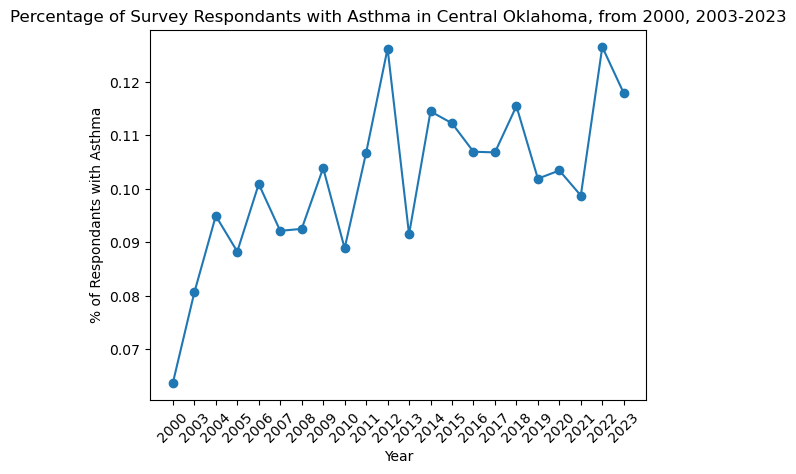

In [27]:
# Filter to the rows with yes and total for asthma, computing the total count, and pivoting to compute a yearly percentage
asthma_survey_filtered_perc_df = processed_survey_df[(processed_survey_df["Asthma"].isin(["Yes", "Total"])) & (processed_survey_df["Metric"] == "n")]
asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)
asthma_survey_filtered_perc_pivoted_df = asthma_survey_filtered_perc_df.pivot_table(index='Year', columns='Asthma', values='Total_Respondants', aggfunc='sum')
asthma_survey_filtered_perc_pivoted_df['Percentage'] = asthma_survey_filtered_perc_pivoted_df['Yes']/asthma_survey_filtered_perc_pivoted_df['Total']


plt.plot(asthma_survey_filtered_perc_pivoted_df["Percentage"], marker='o')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('% of Respondants with Asthma')
plt.title('Percentage of Survey Respondants with Asthma in Central Oklahoma, from 2000, 2003-2023')

Here, we see that the rates of asthma are clearly going up, but we also want to investigate how the rates of smoking might be impacting asthma.

## Smoking Preliminary EDA
Using the same dataset, we visualized the number of respondants who were smokers.

Text(0.5, 1.0, 'Percentage of Respondants who Smoke')

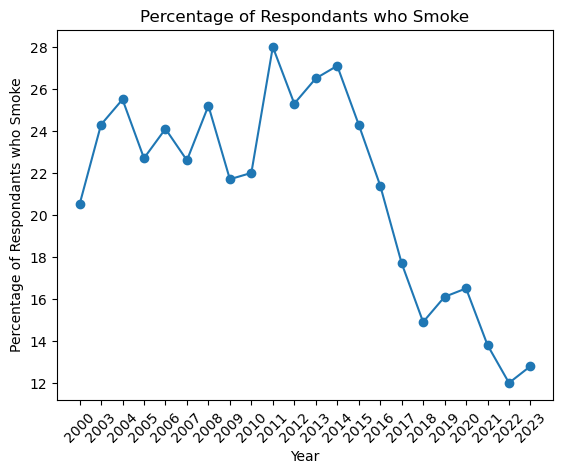

In [31]:
smoking_survey_filtered_df = processed_survey_df[(processed_survey_df["Asthma"] == "Total") & (processed_survey_df["Metric"] == "%")][["Year", "Smoking-Yes"]]

plt.plot(smoking_survey_filtered_df['Year'].astype(str), smoking_survey_filtered_df["Smoking-Yes"], marker='o')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Respondants who Smoke')
plt.title('Percentage of Respondants who Smoke')

Here, we saw that the rates of smoking have been declining drastically. This is especially interesting as we did initially see asthma still increasing -- perhaps the increase in asthma rates would be even more profound among non-smokers.

To answer tjhis question, we then analyzed the rates of asthma stratified on smoking status.


C:\Users\ajnet\AppData\Local\Temp\ipykernel_23028\1195429990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_smoking_asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)


Text(0.5, 1.0, 'Percentage of Non-Smokers with Asthma')

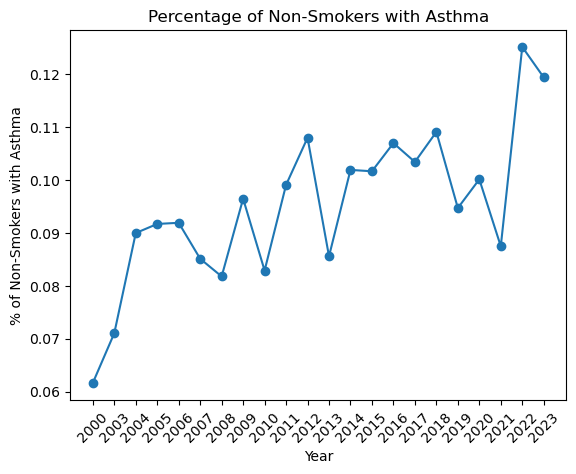

In [26]:
#Computing the asthma rate among non-smokers
non_smoking_asthma_survey_filtered_perc_df = processed_survey_df[(processed_survey_df["Asthma"].isin(["Yes", "Total"])) & (processed_survey_df["Metric"] == "n")]
non_smoking_asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)

non_smoking_asthma_survey_filtered_perc_pivoted_df = non_smoking_asthma_survey_filtered_perc_df.pivot_table(index='Year', columns='Asthma', values='Smoking-No', aggfunc='sum')
non_smoking_asthma_survey_filtered_perc_pivoted_df['Percentage'] = non_smoking_asthma_survey_filtered_perc_pivoted_df['Yes']/non_smoking_asthma_survey_filtered_perc_pivoted_df['Total']


plt.plot(non_smoking_asthma_survey_filtered_perc_pivoted_df["Percentage"], marker='o')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('% of Non-Smokers with Asthma')
plt.title('Percentage of Non-Smokers with Asthma')

C:\Users\ajnet\AppData\Local\Temp\ipykernel_23028\2616553835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoking_asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)


Text(0.5, 1.0, 'Percentage of Smokers with Asthma')

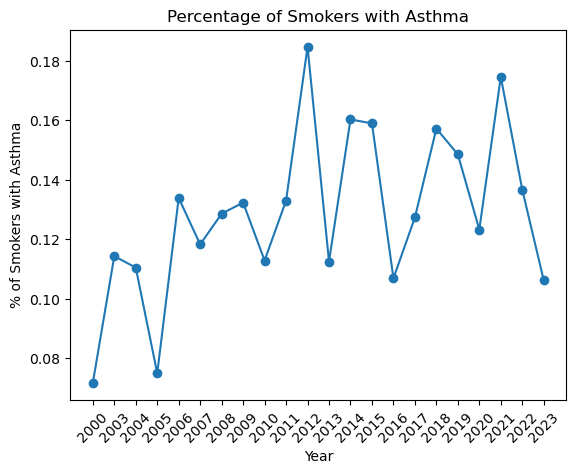

In [30]:
#Computing the asthma rate among smokers
smoking_asthma_survey_filtered_perc_df = processed_survey_df[(processed_survey_df["Asthma"].isin(["Yes", "Total"])) & (processed_survey_df["Metric"] == "n")]#.drop(processed_survey_df.columns[-1], axis=1)
smoking_asthma_survey_filtered_perc_df.rename(columns={'Total':'Total_Respondants'}, inplace=True)

smoking_asthma_survey_filtered_perc_pivoted_df = smoking_asthma_survey_filtered_perc_df.pivot_table(index='Year', columns='Asthma', values='Smoking-Yes', aggfunc='sum')
smoking_asthma_survey_filtered_perc_pivoted_df['Percentage'] = smoking_asthma_survey_filtered_perc_pivoted_df['Yes']/smoking_asthma_survey_filtered_perc_pivoted_df['Total']


plt.plot(smoking_asthma_survey_filtered_perc_pivoted_df["Percentage"], marker='o')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('% of Smokers with Asthma')
plt.title('Percentage of Smokers with Asthma')

Here, we can see that although the rates of asthma have increased for both smokers and non-smokers, the increased rate is much more drastic among the non-smokers. Another note is that for the smoking rate that we saw earlier, although it had decreased dramatically over the past two decades, the current rate is quite low (~12%), so it is unlikely that we would continue to see as drastic of decreases in the smoking rate in future years. Therefore, for our further modeling and analysis, we will use the non-smoker asthma rates as this will help us get a more understanding of the potential isolated impact of wildfire smoke.

In [29]:
# Saving the processed non-smoking asthma survey data for further analysis
non_smoking_asthma_survey_filtered_perc_pivoted_df[['Percentage']].to_csv("../data_clean/asthma_non-smoker_survey_cleaned.csv")